(800, 800)


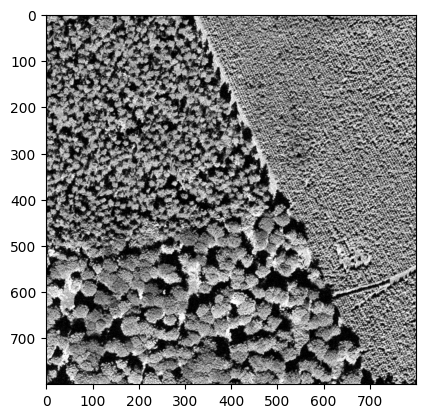

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Load the image
img_name = "b"

# convert to grayscale using PIL
from PIL import Image
img = Image.open(f'data/{img_name}.png').convert('L')
img = np.asarray(img, dtype=np.float32)

# save img as png
# plt.imsave(f'/Users/aleix11alcacer/Downloads/{img_name}.png', img, cmap='gray')

# Display the image
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

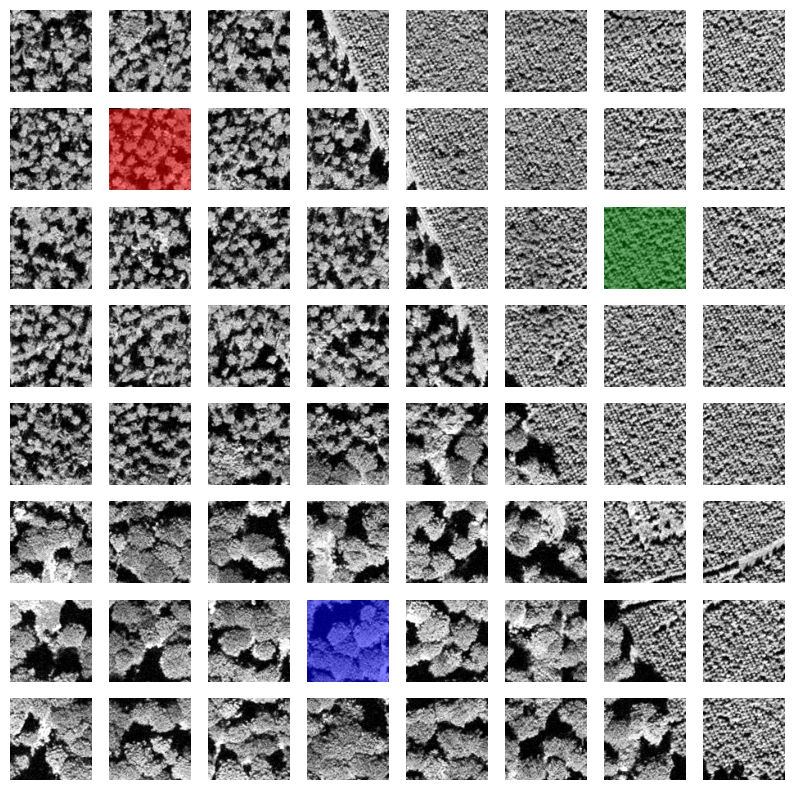

In [13]:
import numpy as np

def tiled_img(img, tile_shape):
    """Return a 3D array of tiles from the input image. The last two dimensions
    of the returned array correspond to the tile shape.
    """
    img = np.asarray(img)
    rows, cols = img.shape
    row_tiles, col_tiles = tile_shape
    return (img.reshape(rows // row_tiles, row_tiles, cols // col_tiles, col_tiles)
            .transpose(0, 2, 1, 3)
            .reshape(-1, row_tiles, col_tiles))
    

tile_shape = (100, 100)
tiles = tiled_img(img, tile_shape)

# Plot 9 random tiles

fig_shape = np.array(img.shape) / np.array(tile_shape)

fig, ax = plt.subplots(*fig_shape.astype(int), figsize=(10, 10))

ind = [9, 22, 51]
c = {9: "r", 22: "g", 51: "b"}

axs = ax.flat
for i, tile in enumerate(tiles):
    axs[i].imshow(tile, cmap='gray', vmin=0, vmax=255)
    axs[i].axis('off')
    if i in ind:
        # Add a semi-transparent red rectangle
        axs[i].add_patch(plt.Rectangle((0, 0), tile_shape[1], tile_shape[0],
                                        fc=c[i], alpha=0.5))

plt.show()


In [13]:
# Define a granulometry function over a list of images
from skimage.morphology import disk, opening

def granulometry(img):
    """Return the granulometry of the input image.
    """
    granulo = []
    sizes = np.arange(1, 25, 2)
    for radius in sizes:
        granulo.append(1 - opening(img, disk(radius)).sum() / img.sum())
    return granulo

# Compute the granulometry of the tiles
granulos = [granulometry(tile) for tile in tiles]


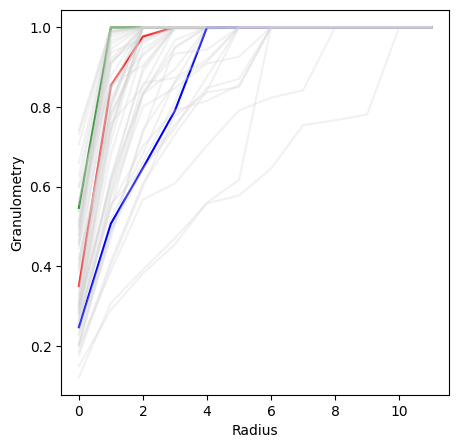

In [14]:
# Plot granulometry curves

fig, ax = plt.subplots(figsize=(5, 5))

cmap = plt.cm.get_cmap('viridis', len(granulos))

for i, granulo in enumerate(granulos):
    if i in ind:
        alpha = 1
        color = c[i]
    else:
        alpha = 0.3
        color = "lightgray"

    ax.plot(granulo, color=color, alpha=alpha)

ax.set(xlabel='Radius', ylabel='Granulometry')
plt.show()


In [25]:
# Save granulometry curves as csv

import pandas as pd

df = pd.DataFrame(granulos)
# df.to_csv(f'results/granulometry_{img_name}.csv', index=False)


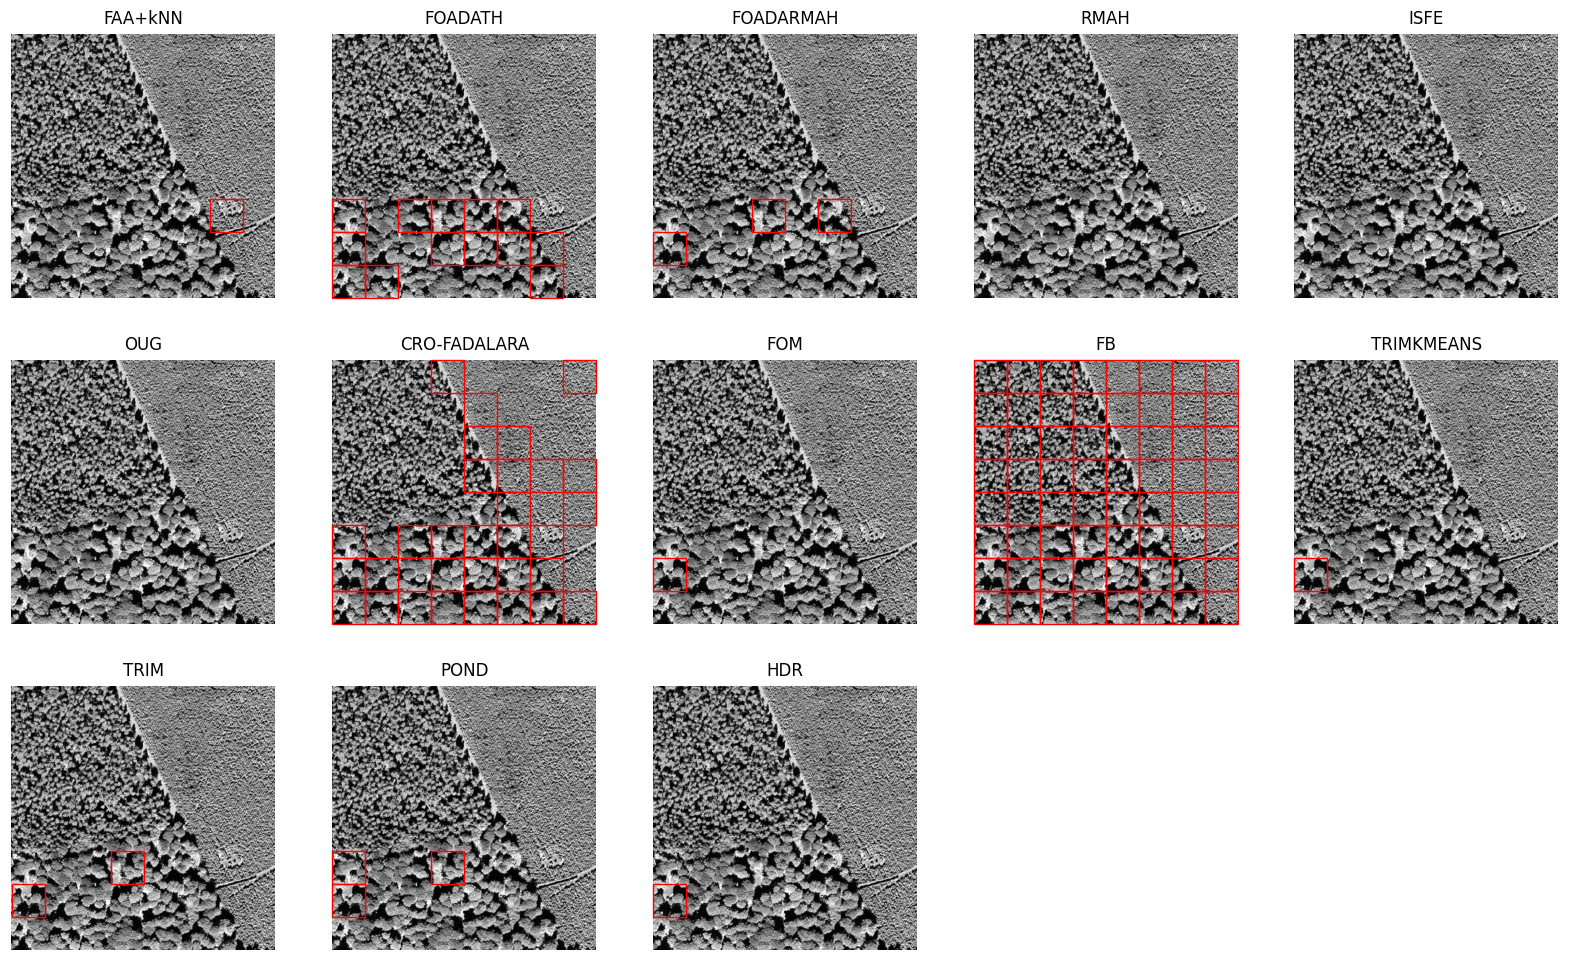

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Load the image
img_name = "b"
img = plt.imread(f'data/{img_name}.png')[:800, :800]
img = np.asarray(img, dtype=np.float32)


# Load RData file generated by granulometries.rmd

import rpy2.robjects as robjects

r = robjects.r
r.load('results/results2.Rdata')
r_results = r['results']
results = {key: np.array(r_results.rx2(key), dtype=np.uint32) for key in r_results.names}

# Plot the results
fig, ax = plt.subplots(3, 5, figsize=(20, 12))
axs = ax.flat

for r_i, (k, v) in enumerate(results.items()):
    axs[r_i].imshow(img, cmap='gray')
    axs[r_i].axis('off')
    # Increase limits to show the red rectangle

    axs[r_i].set_ylim(-5, 805)
    axs[r_i].set_xlim(-5, 805)

    # Invert y axis
    axs[r_i].invert_yaxis()


    for t_i in range(len(tiles)):
        if t_i + 1 in v:
            i, j = np.unravel_index(t_i, fig_shape.astype(int))
            axs[r_i].add_patch(plt.Rectangle((j * tile_shape[1], i * tile_shape[0]),
                                                tile_shape[1], tile_shape[0],
                                                fill=False, edgecolor='red', lw=1))
            
    axs[r_i].set_title(f'{k}')

for ax in axs:
    ax.axis('off')

plt.show()

    
    

In [23]:
# save figure to pdf
fig.savefig(f'results/granulometry_results.pdf', bbox_inches='tight')
